In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

device

device(type='cuda')

In [3]:
from collections import deque

class Memory():
    def __init__(self, capacity=10000, short_capacity=2000):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)
        self.short_memory = deque(maxlen=short_capacity)
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        self.short_memory[-1][-1] = final
        self.memory.extendleft(self.short_memory)
        self.short_memory.clear()

In [48]:
# class Memory():
#     def __init__(self, capacity=10000):
#         self.capacity = capacity
#         self.memory = []
#         self.short_memory = []
        
#     def push(self, old_state, action, reward, new_state, final):
#         self.short_memory.append([old_state, action, reward, new_state, final])
        
#     def commit(self, final=True): 
#         if len(self.memory) + len(self.short_memory) < self.capacity:
#             self.memory.extend(self.short_memory)
#         else:
#             for memo in self.short_memory:
#                 self.memory.insert(random.randint(0, len(self.memory) - 1), memo)
                
#         self.memory = self.memory[:self.capacity]
#         self.short_memory = []

In [49]:
class Qnet(torch.nn.Module):
    def __init__(self, observation_space=None, action_space=None):
        super(Qnet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(observation_space, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, action_space),
        )
    
    def forward(self, x):
        return self.model(x)

In [81]:
class Agent:
    def __init__(self, observation_space=None, action_space=None, device=None):
        self.device = device
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.reset()
    
    def reset(self):
        self._mode = 'train'
        self._episode_count = 0
        self._eps = 0.99999
        self._eps_min = 0.01
        self._gamma = 0.999995
        
        self.policy_net = Qnet(observation_space=self.observation_space, 
                               action_space=self.action_space).to(self.device)
        self.target_net = Qnet(observation_space=self.observation_space, 
                               action_space=self.action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optim = torch.optim.Adam(self.policy_net.parameters(), lr=0.01)
        
        self.memory = Memory(capacity=10000000)  
    
    def push_observation(self, old_state, action, reward, state, final):
        self.memory.push(old_state, action, reward, state, final)
    
    def episode_ended(self):
        self.memory.commit()
        self._episode_count += 1
        
    def get_action(self, state):
        def get_model_action(state):
            with torch.no_grad():
                input = torch.FloatTensor(state).to(self.device)
                model_output = self.policy_net(input.unsqueeze(0))
                model_output = model_output.cpu().detach().numpy()
                return np.argmax(model_output[0])
            
        if self._mode == 'eval':
            return get_model_action(state)
        if self._mode == 'train':
            self._eps *= self._gamma
            self._eps = max(self._eps, self._eps_min)
            if random.random() > self._eps:
                return get_model_action(state)
            else:
                return random.randint(0, self.action_space-1)
        raise "unknown mode"
        
    def train_memory(self, batch_size=64):
        memory = self.memory.memory
        try:
            memory = random.sample(memory, batch_size)
        except ValueError:
            return

        s0 = [x[0] for x in memory]
        a = [x[1] for x in memory]
        r = [x[2] for x in memory]
        s1 = [x[3] for x in memory]
        done = [1. if x[4] else 0. for x in memory]


        s0 = torch.FloatTensor(s0).to(self.device)
        s1 = torch.FloatTensor(s1).to(self.device)
        a = torch.LongTensor(a).to(self.device)
        r = torch.FloatTensor(r).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        q_values = self.policy_net(s0)
        next_q_values = self.target_net(s1)
        next_q_value = next_q_values.max(1)[0]

        q_value = q_values.gather(1, a.unsqueeze(1)).squeeze(1)
        expected_q_value = r + 0.99 * next_q_value * (1.0 - done)
        # Notice that detach the expected_q_value
        loss = (expected_q_value.detach() - q_value).pow(2).mean()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
        def soft_update(target_model, source_model, tau=0.0005):
            for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
                    target_param.data.copy_(tau*source_param.data + (1.0-tau)*target_param.data)
                
        soft_update(self.target_net, self.policy_net)
  
    def train(self):
        self._mode = 'train'
    def eval(self):
        self._mode = 'eval'

In [82]:
env = gym.make('Acrobot-v1')
env._max_episode_steps = 500

In [83]:
agent = Agent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n, device=device)
agent.train()

In [84]:
len_mem = []
try:
    for episode in range(100000):
        state = env.reset()

        for i in count():
            
            action = agent.get_action(state)
            old_state = state
            state, reward, done, info = env.step(action)

            agent.train_memory(batch_size=128)
            
            if done:
                env.close()
                len_mem.append(i)
                
                final = True if reward > -0.5 else False
                
                agent.push_observation(old_state, action, reward, state, final)
                agent.episode_ended()
                break
            else:
                agent.push_observation(old_state, action, reward, state, False)
        
        if episode % 10 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, 
                                                                           np.mean(len_mem[-10:]), 
                                                                           agent._eps))
    
except KeyboardInterrupt:
    env.close()

Episode   0:    499.000 iterations, eps=0.997493
Episode  10:    494.400 iterations, eps=0.973089
Episode  20:    499.000 iterations, eps=0.949063
Episode  30:    499.000 iterations, eps=0.925630
Episode  40:    499.000 iterations, eps=0.902777
Episode  50:    499.000 iterations, eps=0.880487
Episode  60:    499.000 iterations, eps=0.858747
Episode  70:    499.000 iterations, eps=0.837545
Episode  80:    499.000 iterations, eps=0.816866
Episode  90:    499.000 iterations, eps=0.796697
Episode 100:    493.300 iterations, eps=0.777248
Episode 110:    499.000 iterations, eps=0.758058
Episode 120:    499.000 iterations, eps=0.739341
Episode 130:    470.700 iterations, eps=0.722108
Episode 140:    421.300 iterations, eps=0.707020
Episode 150:    449.300 iterations, eps=0.691280
Episode 160:    421.700 iterations, eps=0.676823
Episode 170:    311.800 iterations, eps=0.666319
Episode 180:    309.600 iterations, eps=0.656051
Episode 190:    370.400 iterations, eps=0.643981
Episode 200:    275.

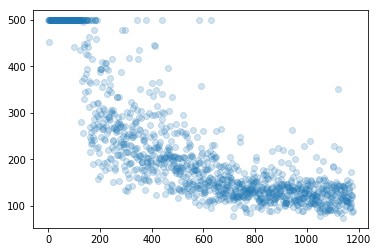

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(len_mem, 'o', alpha=0.2)

In [94]:
agent.eval()

try:
    env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 100000
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
        env.render()
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print (t)

0
84
84


In [12]:
model = policy_net

In [13]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [14]:
torch.save(model, 'model.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
model = torch.load('model.torch')

In [27]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [28]:
policy_net = model